In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [221]:
### Linear Regression Model ###

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_train = linear_reg.predict(X_train)
y_pred_test = linear_reg.predict(X_test)
print('Linear Regression')
print('\nTraining RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)), 'Testing RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTraining R2: ', linear_reg.score(X_train, y_train), 'Testing R2: ', linear_reg.score(X_test, y_test))
print('\nTraining MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train), 'Testing MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))

Linear Regression

Training RMSE: 8.056457397915441 Testing RMSE: 6.920715398395031

Training R2:  0.5918284580076654 Testing R2:  0.669057877740889

Training MAPE:  17.959181386678583 Testing MAPE:  15.069384924845414



This Linear Regression will serve as the base model, below I'll offer some plots we can use for later comparison.


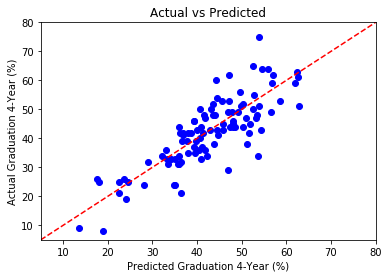

In [222]:
### Actual vs Predicted Scatterplot ###
import matplotlib.pyplot as plt

actual = y_test
predicted = linear_reg.predict(X_test)
plt.scatter(predicted, actual, color='blue')
plt.xlim(5, 80)
plt.ylim(5, 80)
ax = plt.axes()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, linestyle='--', color='red')
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Actual Graduation 4-Year (%)')
plt.title('Actual vs Predicted')
plt.show()


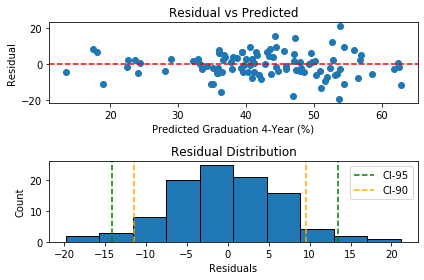

   CI  lower bound  upper bound   CI Range
0  90   -11.387778     9.553608  20.941385
1  95   -14.172749    13.498170  27.670919


In [223]:
### Predicted vs Residuals Scatterplot ###
plt.subplot(2,1,1)
residuals = actual - predicted
plt.scatter(predicted, residuals)
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Residual')
plt.title('Residual vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')

### Residuals Histogram ###
plt.subplot(2,1,2)
plt.hist(residuals, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Distribution')
conf_int95 = np.percentile(residuals, [2.5, 97.5])
conf_int90 = np.percentile(residuals, [5, 95])
plt.axvline(x=conf_int95[0], color='green', linestyle='--', label='CI-95')
plt.axvline(x=conf_int95[1], color='green', linestyle='--')
plt.axvline(x=conf_int90[0], color='orange', linestyle='--', label='CI-90')
plt.axvline(x=conf_int90[1], color='orange', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()
conf_ints = pd.DataFrame({'CI': [90, 95], 'lower bound': [conf_int90[0], conf_int95[0]], 'upper bound': [conf_int90[1], conf_int95[1]]})
conf_ints["CI Range"] = abs(conf_ints['upper bound'] - conf_ints['lower bound'])
print(conf_ints)

Moving Forward:

I believe a random forest regression will solve many of the concerns with the size of the dataset and the random state influence. Each tree will draw a random sample from the original data set when generating its splits, adding a further element of randomness that prevents overfitting.

The number of features that can be split on at each node is limited to some percentage of the total, which also helps ensure that the ensemble model does not rely too heavily on any individual feature. This makes fair use of all potentially predictive features and helps the issues of multicollinearity. 


OOB Score 0.6200296049737553

Testing RMSE: 6.697633494769493

Testing R2:  0.6900491550323685

Testing MAPE:  15.537372871022617


____Feature Importance Plot_____


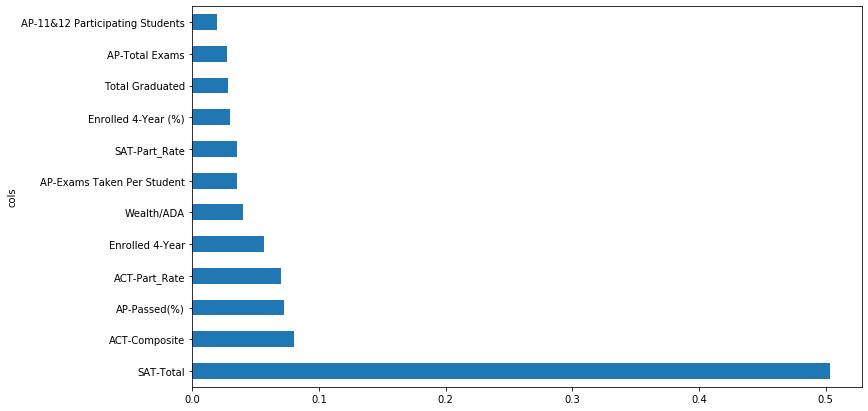

In [181]:
####### Base RandomForestRegressor (No HyperParameter Tuning) Model #########
### Analyzing Importance of All Features ###

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True)
rfr.fit(X_train, y_train)
y_pred_test = rfr.predict(X_test)
fi = rf_feat_importance(rfr, grad[grad.columns[:-1]])
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi)
print('OOB Score', rfr.oob_score_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', rfr.score(X_test, y_test))
print('\nTesting MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))
print('\n\n____Feature Importance Plot_____')
plt.show()


In [204]:
### RandomForestRegressor with HyperParameter Tuning ###
### Dropping Certain Features ###
scorers = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'}

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
grad = grad.drop(['AP-11&12 Participating Students', 'AP-Total Exams', 'Total Graduated', 'Enrolled 4-Year (%)'], axis=1)
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
rfr = RandomForestRegressor(n_jobs=-1, oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = scorers, refit = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
OOB = grid_search.best_estimator_
print('\nOOB Score: ', OOB.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))
print('\nTesting MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))


OOB Score:  0.6285669955280373

Best Params: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}

Testing RMSE: 6.638408908817794

Testing R2:  0.6955064706119141

Testing MAPE:  15.385681449058072


The above is the best model so far  

Best RandomForestRegressor Hyperparameters:
    max_features = 'log2'
    min_samples_leaf = 1
    n_estimators = 200
    
Below I will plot the same figures I did with the Linear Regression model to make my decision on which model to select. 


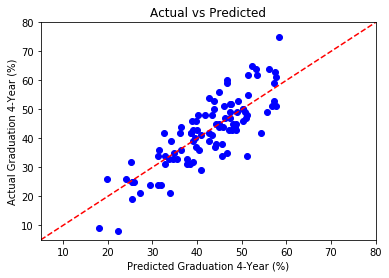

In [211]:
### Actual vs Predicted Scatterplot ###
actual = y_test
predicted = grid_search.predict(X_test)
plt.scatter(predicted, actual, color='blue')
plt.xlim(5, 80)
plt.ylim(5, 80)
ax = plt.axes()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, linestyle='--', color='red')
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Actual Graduation 4-Year (%)')
plt.title('Actual vs Predicted')
plt.show()


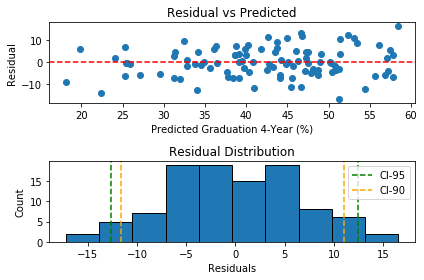

   CI  lower bound  upper bound   CI Range
0  90   -11.623250    11.008000  22.631250
1  95   -12.676903    12.397875  25.074778


In [212]:
### Predicted vs Residuals Scatterplot ###
plt.subplot(2,1,1)
residuals = actual - predicted
plt.scatter(predicted, residuals)
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Residual')
plt.title('Residual vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')

### Residuals Histogram ###
plt.subplot(2,1,2)
plt.hist(residuals, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Distribution')
conf_int95 = np.percentile(residuals, [2.5, 97.5])
conf_int90 = np.percentile(residuals, [5, 95])
plt.axvline(x=conf_int95[0], color='green', linestyle='--', label='CI-95')
plt.axvline(x=conf_int95[1], color='green', linestyle='--')
plt.axvline(x=conf_int90[0], color='orange', linestyle='--', label='CI-90')
plt.axvline(x=conf_int90[1], color='orange', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()
conf_ints = pd.DataFrame({'CI': [90, 95], 'lower bound': [conf_int90[0], conf_int95[0]], 'upper bound': [conf_int90[1], conf_int95[1]]})
conf_ints["CI Range"] = abs(conf_ints['upper bound'] - conf_ints['lower bound'])
print(conf_ints)

The RandomForestRegressor will be the model I select to predict college graduation %.

In all the metrics (r2, rmse, mape) it outperformed the linear regression and the basic random forest without hyperparameter tuning (which it had a better out of bag score than as well). 

The distribution of residuals also made me more comfortable in moving forward with the optimized RandomForestRegressor. The CI-95 range is smaller as well as the overall range of residuals. The lower and upper bound are also a bit more symmetrical, more closely resembling a normal distribution. 

In [213]:
### Filling In / Predicting 2015, 2016, 2017 ###
historical = pd.read_csv('Feature_Target_Data.csv')
historical = historical.fillna('NaN')
predicted = historical[historical.columns[3:]]
predicted = predicted.drop(['AP-11&12 Participating Students', 'AP-Total Exams', 'Total Graduated', 'Enrolled 4-Year (%)'], axis=1)
columns = list(predicted.columns[:-1])
for idx, row in historical.iterrows():
    if row['Graduated 4-Year (%)'] == 'NaN':
        features = [row[col] for col in columns]
        features = np.array(features).reshape(1, -1)
        historical.loc[idx, 'Graduated 4-Year (%)'] = grid_search.predict(features)
historical.to_csv('Hist_Pred_Data.csv', index=False)

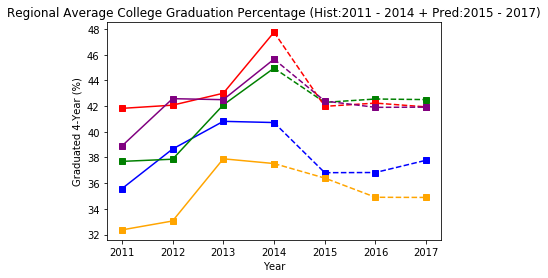

In [214]:
## Graph Showing Regional College Graduation Trends + Predictions for Class of 2015, 2016, 2017#### 
total = pd.read_csv('Hist_Pred_Data.csv')
total1 = total.loc[total['Year'].isin([2011, 2012, 2013, 2014])]
total2 = total.loc[total['Year'].isin([2014, 2015, 2016, 2017])]
major_regions = ['Houston', 'San Antonio', 'Austin', 'Richardson', 'Fort Worth']
color_dict = dict({'Houston':'blue',
                  'San Antonio':'orange',
                  'Austin': 'green',
                  'Richardson': 'red',
                   'Fort Worth': 'purple'})

for region in major_regions:
    region_total = total1.loc[total['RegnName'] == region]
    sat_trend = pd.pivot_table(region_total, index='Year', values='Graduated 4-Year (%)', aggfunc=np.mean)
    sat_trend = pd.DataFrame(sat_trend.to_records())
    plt.plot(sat_trend['Year'], sat_trend['Graduated 4-Year (%)'], color=color_dict[region], marker='s', label=region)
for region in major_regions:
    region_total = total2.loc[total['RegnName'] == region]
    sat_trend = pd.pivot_table(region_total, index='Year', values='Graduated 4-Year (%)', aggfunc=np.mean)
    sat_trend = pd.DataFrame(sat_trend.to_records())
    plt.plot(sat_trend['Year'], sat_trend['Graduated 4-Year (%)'], color=color_dict[region], marker='s', linestyle='--', label=region)

plt.xlabel('Year')
plt.ylabel('Graduated 4-Year (%)')
plt.title('Regional Average College Graduation Percentage (Hist:2011 - 2014 + Pred:2015 - 2017)')
plt.xticks([2011, 2012, 2013, 2014, 2015, 2016, 2017])
plt.show()

In [215]:
### Function to provide top # of options for year and region ###
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def top_5_options(year, region, options):
    total = pd.read_csv('Hist_Pred_Data.csv')
    year_region = total.loc[(total['Year'] == year) & (total['RegnName'] == region)][['DistName', 'RegnName', 'Year', 'Graduated 4-Year (%)']]
    year_region = year_region.sort_values('Graduated 4-Year (%)', ascending=False).reset_index(drop=True)
    grad_year = year + 4
    if year > 2014:
        year_region.columns = ['DistName', 'RegnName', 'Class Year', 'Pred. ' + str(grad_year) + ' College Graduation (%)']
    else:
         year_region.columns = ['DistName', 'RegnName', 'Class Year', str(grad_year) + ' College Graduation (%)']
    print('\n', year_region.head(options))
region = input("What region are you interested in? (Houston/San Antonio/Fort Worth/Richardson/Austin) ")
year = int(input("What high school class year of students are you interested in? "))
options = int(input("How many different districts in your chosen region would you like to view? "))

top_5_options(year, region, options)

What region are you interested in? (Houston/San Antonio/Fort Worth/Richardson/Austin) Richardson
What high school class year of students are you interested in? 2015
How many different districts in your chosen region would you like to view? 8

          DistName    RegnName  Class Year  Pred. 2019 College Graduation (%)
0      CELINA ISD  Richardson        2015                          60.924502
1       PLANO ISD  Richardson        2015                          57.885000
2       ALLEN ISD  Richardson        2015                          57.790000
3     LOVEJOY ISD  Richardson        2015                          57.225000
4      FRISCO ISD  Richardson        2015                          53.360000
5     PROSPER ISD  Richardson        2015                          52.535000
6     COPPELL ISD  Richardson        2015                          52.310000
7  MIDLOTHIAN ISD  Richardson        2015                          51.875000


In [217]:
### Function to look up forecast for specific district ###
def district_forecast(district, year):
    total = pd.read_csv('Hist_Pred_Data.csv')
    district = total.loc[(total['DistName'] == district) & (total['Year'] == year)][['DistName', 'RegnName', 'Year', 'Graduated 4-Year (%)']].reset_index(drop=True)
    grad_year = year + 4
    if year > 2014:
        district.columns = ['DistName', 'RegnName', 'Class Year', 'Pred. ' + str(grad_year) + ' College Graduation (%)']
    else:
         district.columns = ['DistName', 'RegnName', 'Class Year', str(grad_year) + ' College Graduation (%)']
    print('\n', district)

district = str.upper(input("What specific district are you interested in? "))
year = int(input("What high school class year are you interested in? "))
district_forecast(district, year)


What specific district are you interested in? katy isd
What high school class year are you interested in? 2016

    DistName RegnName  Class Year  Pred. 2020 College Graduation (%)
0  KATY ISD  Houston        2016                              50.43


In [17]:
### New school district (has less than 7 years in existance, predict college grad % for students from certain class based on their features ###
def predict_col_grad(feature_list):
    district_features = np.array(feature_list).reshape(1, -1)
    forecasted_grad = grid_search.predict(district_features)
    print(forecasted_grad)
